In [1]:
# Load cocde and do it for plotting 
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from dt import *
import torch
import pandas as pd



2025-06-25 18:56:06.779 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-25 18:56:06.782 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 18:56:06.782 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 18:56:06.783 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 18:56:06.783 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 18:56:06.842 
  command:

    streamlit run /opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-pac

In [2]:
import numpy as np
import pandas as pd

# Set seeds
import random
random.seed(42)
np.random.seed(42)

# Load data (as in your code)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)
try:
    Y = np.load("Y.npy")
except Exception:
    import torch
    Y = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/Y_tensor.pt")
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()

disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()
disease_name = "Type 2 diabetes"  # or your disease of interest
disease_idx = disease_names.index(disease_name)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_44358/1290113826.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load("/Users/sarahurbut/Library/Cl

In [8]:
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_44358/2028457158.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G = torch.load("/Users/sarahurbut/Library/Clo

In [17]:
print(G.shape)
print(Y.shape)


(407878, 36)
(407878, 348, 52)


In [11]:

covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov = pd.read_csv(covariate_path, sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['enrollment'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['year_of_birth']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    if isinstance(presc_date, str):
        presc_date = pd.to_datetime(presc_date, errors='coerce')
    if pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid + 30 - age_at_presc)))


In [34]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")


Number of unique individuals in statins: 78028


In [40]:
df_drug.head()

,eid,from,to,category,type,year_of_birth
453033,1000015,2008-04-24,2015-04-04,statins,any,1938.0
453034,1000015,2015-04-20,2016-08-30,statins,any,1938.0
453035,1000198,2013-05-14,2014-01-26,statins,any,1948.0
453036,1000198,2014-01-28,2014-12-15,statins,any,1948.0
453037,1000198,2014-12-16,2017-05-27,statins,any,1948.0


In [41]:
processed_ids

array([1000015, 1000023, 1000037, ..., 5929627, 5929638, 5929643])

In [42]:
disease_names[112]

'Myocardial infarction'

In [135]:
# Assuming pce_df has columns: 'id', 'dm2_prev', 'antihtnbase', 'dm1_prev'
eid_to_dm2_prev = dict(zip(pce_df['id'], pce_df['dm2_prev']))
eid_to_antihtnbase = dict(zip(pce_df['id'], pce_df['antihtnbase']))
eid_to_dm1_prev = dict(zip(pce_df['id'], pce_df['dm1_prev']))

2025-06-26 13:09:36.231 No runtime found, using MemoryCacheStorageManager
2025-06-26 13:09:36.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:09:36.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:09:36.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:09:36.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:09:36.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [137]:
from dt import *
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

eid_to_sex = dict(zip(pce_df['id'], pce_df['Sex']))

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=112,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    
    max_cases=10000,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=eid_to_sex,
    eid_to_dm2_prev=eid_to_dm2_prev,
    eid_to_antihtnbase=eid_to_antihtnbase,
    eid_to_dm1_prev=eid_to_dm1_prev,
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

2025-06-26 13:58:35.196 No runtime found, using MemoryCacheStorageManager


Raw Treated Event Rate: 12.70% (n=63610)
Raw Untreated Event Rate: 4.48% (n=331624)


2025-06-26 13:59:02.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:59:02.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:59:02.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:59:03.082 Thread 'Thread-126': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 13:59:03.083 Thread 'Thread-126': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 500/9954 treated. Elapsed: 21.7 min. Est. remaining: 409.6 min.
Processed 1000/9954 treated. Elapsed: 35.1 min. Est. remaining: 314.1 min.
Processed 1500/9954 treated. Elapsed: 48.6 min. Est. remaining: 273.9 min.
Processed 2000/9954 treated. Elapsed: 65.6 min. Est. remaining: 261.0 min.
Processed 2500/9954 treated. Elapsed: 80.2 min. Est. remaining: 239.2 min.
Processed 3000/9954 treated. Elapsed: 93.7 min. Est. remaining: 217.2 min.
Processed 3500/9954 treated. Elapsed: 107.9 min. Est. remaining: 198.9 min.
Processed 4000/9954 treated. Elapsed: 121.4 min. Est. remaining: 180.6 min.
Processed 4500/9954 treated. Elapsed: 134.8 min. Est. remaining: 163.3 min.
Processed 5000/9954 treated. Elapsed: 148.6 min. Est. remaining: 147.2 min.
Processed 5500/9954 treated. Elapsed: 161.9 min. Est. remaining: 131.1 min.
Processed 6000/9954 treated. Elapsed: 175.7 min. Est. remaining: 115.8 min.
Processed 6500/9954 treated. Elapsed: 188.8 min. Est. remaining: 100.3 min.
Processed 7000/9954

2025-06-26 18:52:08.207 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-26 18:52:08.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Treated event rate: 0.06805172779308882
Control event rate: 0.03593385626457494
Number of matched pairs: 9954


In [138]:
prs_names=pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()
# Unmatched
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

# Matched
matched_treated_indices = [pair[0] for pair in match_result['matched_pairs']]
matched_control_indices = [pair[1] for pair in match_result['matched_pairs']]

means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)
means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)


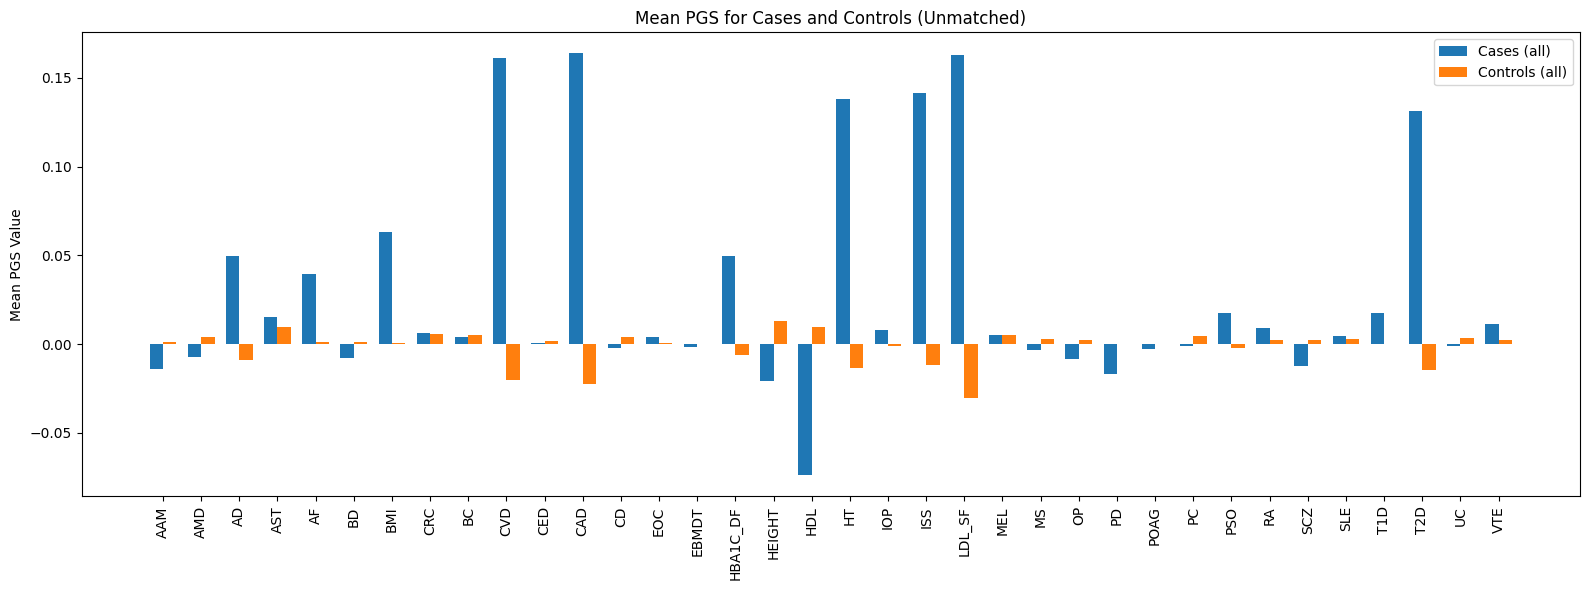

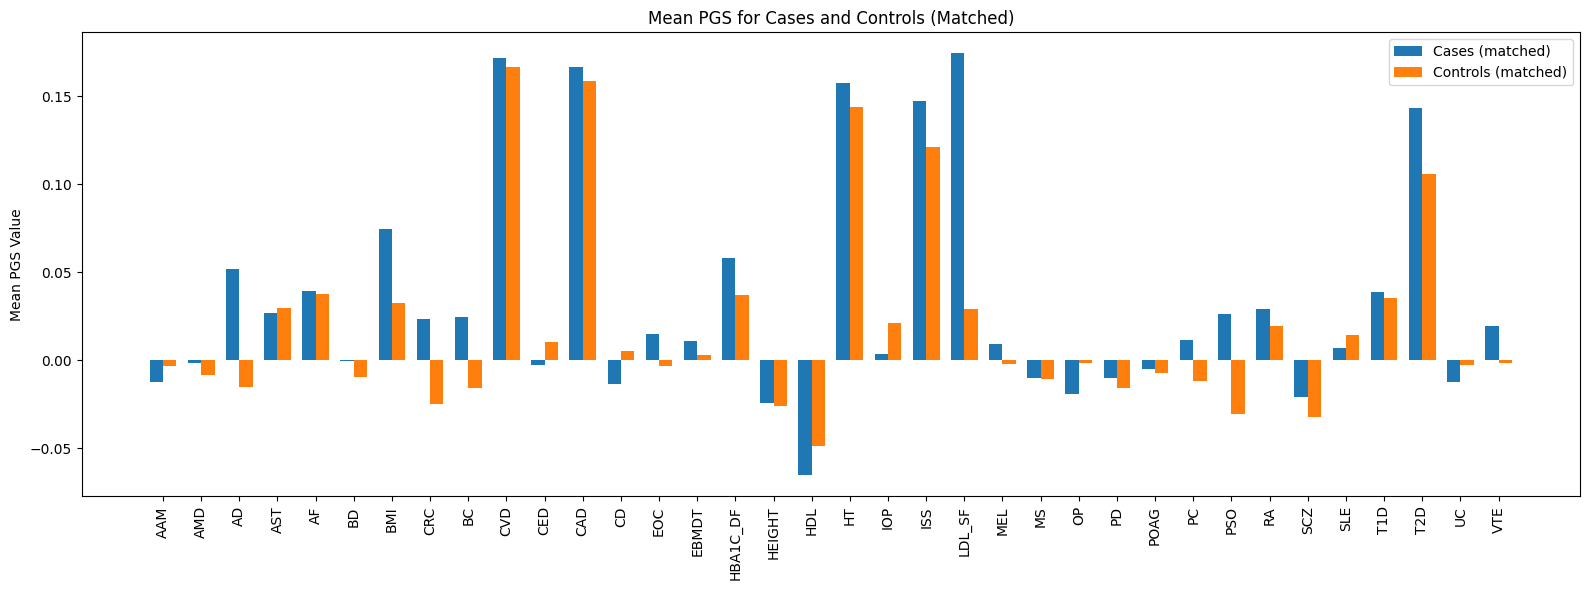

In [139]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(prs_labels))  # 36 PRS
width = 0.35  # width of the bars

# Unmatched
fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
rects2 = ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Matched
fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
rects2 = ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [140]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/CloudStorage/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame

In [141]:
pce_df=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox/pce_zy_2.csv')

In [142]:
# Convert matched indices to IDs
matched_treated_ids = [processed_ids[idx] for idx in [pair[0] for pair in match_result['matched_pairs']]]
matched_control_ids = [processed_ids[idx] for idx in [pair[1] for pair in match_result['matched_pairs']]]

In [143]:
# Unmatched
treated_unmatched = pce_df[pce_df['id'].isin(treated_eids)]
untreated_unmatched = pce_df[pce_df['id'].isin(untreated_eids)]

# Matched
treated_matched = pce_df[pce_df['id'].isin(matched_treated_ids)]
control_matched = pce_df[pce_df['id'].isin(matched_control_ids)]

In [144]:
import pandas as pd

covariates = ['age', 'tchol', 'hdl', 'SBP', 'pce_goff']
summary = pd.DataFrame(index=covariates)

groups = {
    'Treated (all)': treated_unmatched,
    'Control (all)': untreated_unmatched,
    'Treated (matched)': treated_matched,
    'Control (matched)': control_matched
}

for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()

# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))

# Display as a nice table
summary.round(2)

Treated (all)        Control (all)        Treated (matched)         \
                  mean    std          mean    std              mean    std   
age              60.63   6.48         56.61   8.03             60.75   6.43   
tchol           213.60  52.46        220.84  42.89            213.24  52.38   
hdl              51.81  13.88         56.51  14.82             51.79  13.83   
SBP             145.62  19.61        139.18  19.57            145.72  19.50   
pce_goff          0.13   0.08          0.08   0.07              0.13   0.08   

         Control (matched)         
                      mean    std  
age                  60.55   6.44  
tchol               214.51  45.84  
hdl                  54.29  14.49  
SBP                 144.22  19.63  
pce_goff              0.12   0.08

In [145]:
categorical_covariates = ['race', 'Sex', 'SmokingStatusv2','dm2_prev',"antihtnbase",'dm1_prev']

for cov in categorical_covariates:
    # Get all possible categories
    categories = set(
        treated_unmatched[cov].dropna().unique().tolist() +
        untreated_unmatched[cov].dropna().unique().tolist() +
        treated_matched[cov].dropna().unique().tolist() +
        control_matched[cov].dropna().unique().tolist()
    )
    cat_summary = pd.DataFrame(index=sorted(categories))
    for group_name, df in groups.items():
        cat_summary[group_name] = df[cov].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{cov} distribution table:")
    display(cat_summary.round(3))


race distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
asian,0.030,0.020,0.029,0.021
black,0.009,0.017,0.009,0.013
mixed,0.004,0.006,0.003,0.004
other,0.007,0.009,0.007,0.008
white,0.949,0.948,0.952,0.954



Sex distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
Female,0.43,0.567,0.429,0.432
Male,0.57,0.433,0.571,0.568



SmokingStatusv2 distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
Current,0.127,0.105,0.122,0.089
Never,0.459,0.547,0.471,0.514
Previous,0.414,0.348,0.408,0.397



dm2_prev distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.89,0.978,0.9,0.909
1,0.11,0.022,0.1,0.091



antihtnbase distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.624,0.852,0.613,0.623
1,0.376,0.148,0.387,0.377



dm1_prev distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.983,0.996,0.984,0.985
1,0.017,0.004,0.016,0.015


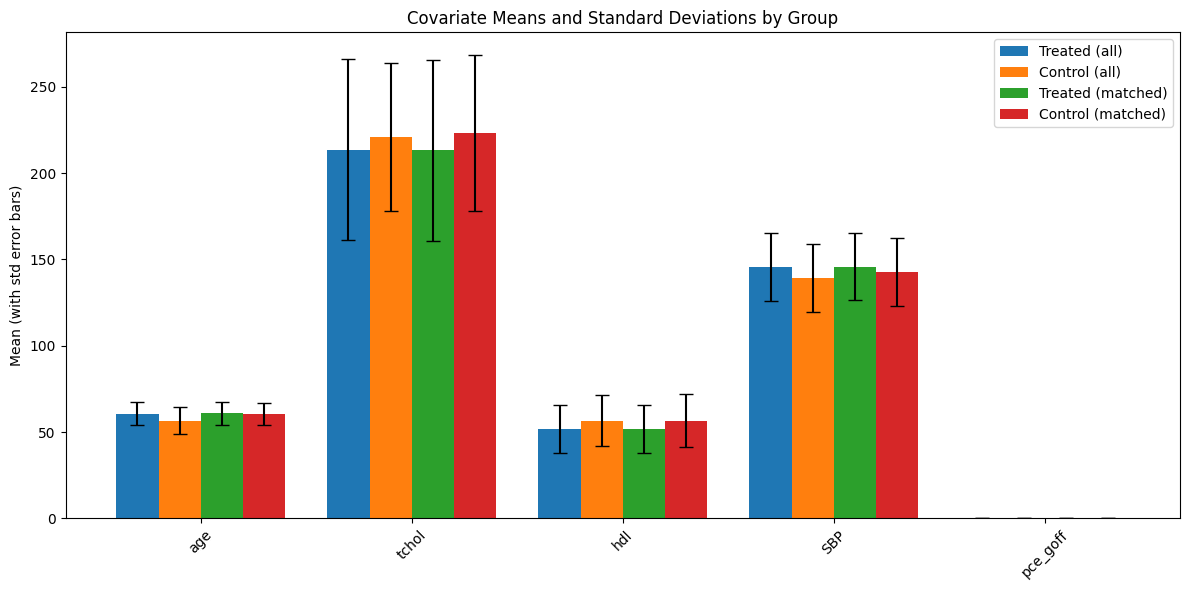

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your summary
covariates = ['age', 'tchol', 'hdl', 'SBP', 'pce_goff']
group_labels = ['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)']
means = [
    [60.63, 213.60, 51.81, 145.62, 0.127],   # Treated (all)
    [56.61, 220.84, 56.51, 139.18, 0.077],   # Control (all)
    [60.75, 213.24, 51.79, 145.72, 0.127],   # Treated (matched)
    [60.61, 223.17, 56.58, 142.84, 0.103],   # Control (matched)
]
stds = [
    [6.48, 52.46, 13.88, 19.61, 0.084],      # Treated (all)
    [8.03, 42.89, 14.82, 19.57, 0.070],      # Control (all)
    [6.43, 52.38, 13.83, 19.50, 0.084],      # Treated (matched)
    [6.41, 45.03, 15.16, 19.85, 0.074],      # Control (matched)
]

means = np.array(means)
stds = np.array(stds)

x = np.arange(len(covariates))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(4):
    ax.bar(x + (i-1.5)*width, means[i], width, yerr=stds[i], capsize=5, label=group_labels[i])

ax.set_xticks(x)
ax.set_xticklabels(covariates, rotation=45)
ax.set_ylabel('Mean (with std error bars)')
ax.set_title('Covariate Means and Standard Deviations by Group')
ax.legend()
plt.tight_layout()
plt.show()

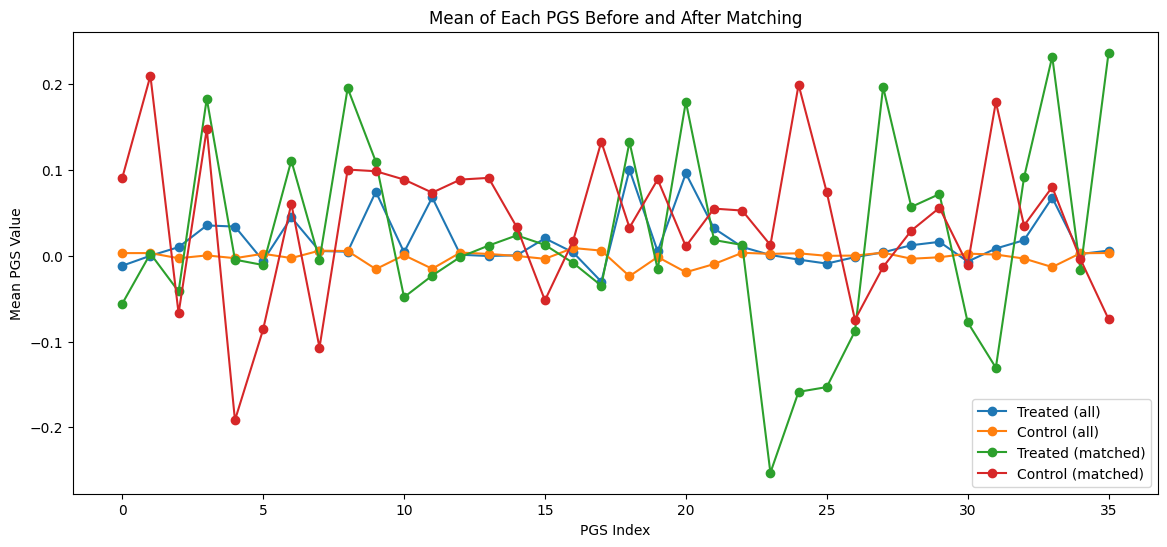

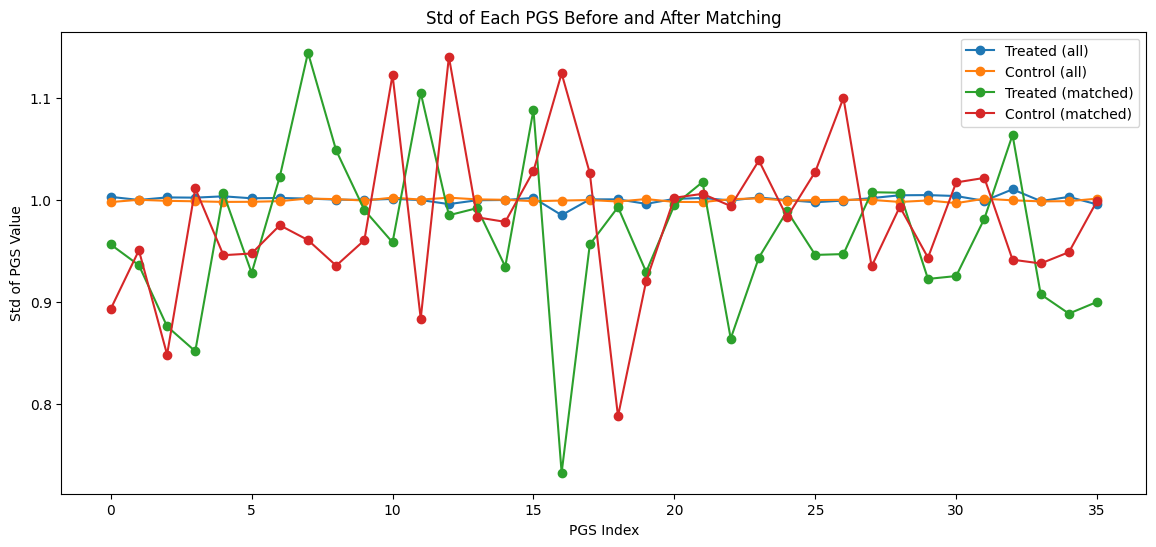

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Indices for each group
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]
matched_treated_indices = [pair[0] for pair in match_result['matched_pairs']]
matched_control_indices = [pair[1] for pair in match_result['matched_pairs']]

# Calculate means and stds for each PGS
means = {
    'Treated (all)': G[treated_indices].mean(axis=0),
    'Control (all)': G[untreated_indices].mean(axis=0),
    'Treated (matched)': G[matched_treated_indices].mean(axis=0),
    'Control (matched)': G[matched_control_indices].mean(axis=0),
}
stds = {
    'Treated (all)': G[treated_indices].std(axis=0),
    'Control (all)': G[untreated_indices].std(axis=0),
    'Treated (matched)': G[matched_treated_indices].std(axis=0),
    'Control (matched)': G[matched_control_indices].std(axis=0),
}

# Plot means for all 36 PGS
plt.figure(figsize=(14, 6))
for label, mean in means.items():
    plt.plot(range(36), mean, marker='o', label=label)
plt.xlabel('PGS Index')
plt.ylabel('Mean PGS Value')
plt.title('Mean of Each PGS Before and After Matching')
plt.legend()
plt.show()

# Optionally, plot standard deviations
plt.figure(figsize=(14, 6))
for label, std in stds.items():
    plt.plot(range(36), std, marker='o', label=label)
plt.xlabel('PGS Index')
plt.ylabel('Std of PGS Value')
plt.title('Std of Each PGS Before and After Matching')
plt.legend()
plt.show()

rho stats: min = 0.24314624071121216 max = 4.247594833374023 mean = 1.1173560619354248
t_warped stats: min = 0.0 max = 49.0 mean = 25.21613883972168
t_warped[0, 0, :10]: [0.         0.416666   0.97394663 1.6004363  2.2765765  2.9922118
 3.740981   4.518477   5.3214426  6.1473613 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0636, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 8.70473249037218e-10 max = 0.0636490136384964
phi min/max: -20.861984252929688 -2.68860125541687
phi_prob_warped min/max: 8.70473249037218e-10 0.0636490136384964
theta min/max: 0.001628373865969479 0.8872731924057007
pi (before clamp) min/max: 5.3094511009987855e-09 0.22442182898521423
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([4.5719], requires_grad=True)


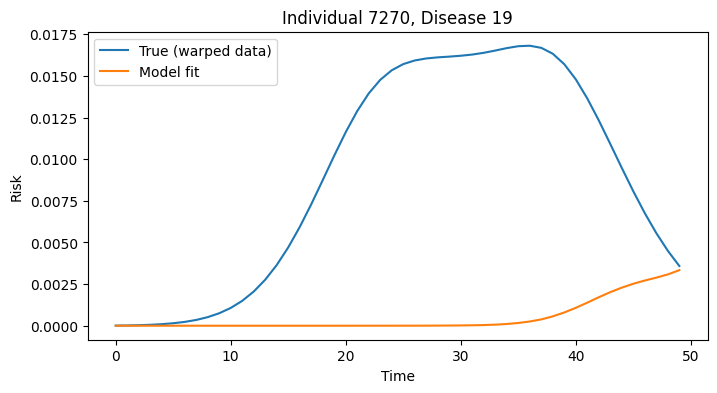

In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

IPW Treated Event Rate: 6.16%
IPW Untreated Event Rate: 5.02%


In [ ]:
import numpy as np
import pandas as pd
del disease_idx

# Set seeds
import random
random.seed(42)
np.random.seed(42)

# Load data (as in your code)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)
try:
    Y = np.load("Y.npy")
except Exception:
    import torch
    Y = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/Y_tensor.pt")
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()

disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()
disease_name = "Myocardial infarction"  # or your disease of interest
print(disease_name)
disease_idx = disease_names.index(disease_name)
print(disease_idx)
covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov = pd.read_csv(covariate_path, sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['enrollment'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['year_of_birth']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    if isinstance(presc_date, str):
        presc_date = pd.to_datetime(presc_date, errors='coerce')
    if pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid + 30 - age_at_presc)))
first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=disease_idx,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=100,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None)
# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_57182/2969738741.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load("/Users/sarahurbut/Library/Cl

Myocardial infarction
112
Raw Treated Event Rate: 3.80% (n=112982)
Raw Untreated Event Rate: 2.60% (n=282177)
Treated event rate: 0.05319148936170213
Control event rate: 0.0425531914893617
Number of matched pairs: 97


In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

IPW Treated Event Rate: 3.47%
IPW Untreated Event Rate: 2.77%


In [11]:
disease_names

['Bacterial enteritis',
 'Viral Enteritis',
 'Gram negative septicemia',
 'Bacterial infection NOS',
 'Staphylococcus infections',
 'Streptococcus infection',
 'E. coli',
 'Viral warts & HPV',
 'Viral infection',
 'Candidiasis',
 'Colon cancer',
 'Malignant neoplasm of rectum, rectosigmoid junction, and anus',
 'Neoplasm of unspecified nature of digestive system',
 'Cancer of bronchus; lung',
 'Melanomas of skin',
 'Other non-epithelial cancer of skin',
 'Breast cancer [female]',
 'Malignant neoplasm of female breast',
 'Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]',
 'Malignant neoplasm of uterus',
 'Malignant neoplasm of ovary',
 'Cancer of prostate',
 'Malignant neoplasm of kidney, except pelvis',
 'Malignant neoplasm of bladder',
 'Malignant neoplasm, other',
 'Secondary malignant neoplasm',
 'Secondary malignancy of lymph nodes',
 'Secondary malignancy of respiratory organs',
 'Secondary malignant neoplasm of digestive systems',
 'Secondary malignant neoplasm of l

In [28]:
major_diseases = [
    "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis",
    "Essential hypertension", "Congestive heart failure (CHF) NOS", 'Other acute and subacute forms of ischemic heart disease',
        'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris'
    ]

In [29]:
df_treat['category'].unique()

array(['anti_hypertensives', 'antipsychotics', 'diabetes', 'statins',
       'steroids'], dtype=object)

In [30]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

47
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
112
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
114
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
109
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (10

In [ ]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

47
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
112
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
114
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
109
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (10

In [32]:
drug_category = "All"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []


for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    # Set seeds
    import random
    random.seed(42)
    np.random.seed(42)

    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

47
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:35:31.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:31.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:31.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:31.679 Thread 'Thread-70': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:31.703 Thread 'Thread-70': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:43.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:35:43.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (12.4 sec)
Treated event rate: 0.032
Control event rate: 0.043
112
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:36:36.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:36.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:36.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:37.383 Thread 'Thread-71': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:37.383 Thread 'Thread-71': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:49.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:36:49.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (12.2 sec)
Treated event rate: 0.053
Control event rate: 0.043
114
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:37:41.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:41.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:41.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:42.163 Thread 'Thread-72': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:42.163 Thread 'Thread-72': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:53.394 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:37:53.394 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.7 sec)
Treated event rate: 0.043
Control event rate: 0.043
109
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:38:45.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:45.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:45.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:45.764 Thread 'Thread-73': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:45.765 Thread 'Thread-73': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:56.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:38:56.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.7 sec)
Treated event rate: 0.298
Control event rate: 0.149
130
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:39:49.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:39:49.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:39:49.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:39:49.586 Thread 'Thread-74': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:39:49.587 Thread 'Thread-74': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:00.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:00.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.8 sec)
Treated event rate: 0.011
Control event rate: 0.000
116
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:40:52.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:52.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:52.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:52.997 Thread 'Thread-75': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:40:52.998 Thread 'Thread-75': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:04.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:04.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.7 sec)
Treated event rate: 0.011
Control event rate: 0.000
111
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:41:55.719 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:55.719 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:55.719 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:56.225 Thread 'Thread-76': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:41:56.225 Thread 'Thread-76': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:07.413 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:07.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.7 sec)
Treated event rate: 0.011
Control event rate: 0.011
113
Number of treated: 117817
Number of controls: 282183
Sample treated_time_idx_cat: [(1000015, 37), (1000169, 35), (1000198, 35), (1000273, 23), (1000296, 41)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]


2025-05-31 12:42:59.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:59.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:59.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:59.562 Thread 'Thread-77': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:42:59.563 Thread 'Thread-77': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:43:10.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-31 12:43:10.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Processed 100/100 treated. Elapsed: 0.2 min. Est. remaining: 0.0 min.

Matching complete. Total elapsed time: 0.2 min (11.7 sec)
Treated event rate: 0.032
Control event rate: 0.032
                                             disease  raw_treated_rate  \
0                                    Type 2 diabetes          6.307199   
1                              Myocardial infarction          3.798835   
2                           Coronary atherosclerosis          6.232851   
3                             Essential hypertension         26.128056   
4                 Congestive heart failure (CHF) NOS          0.751447   
5  Other acute and subacute forms of ischemic hea...          0.420421   
6   Unstable angina (intermediate coronary syndrome)          1.525022   
7                                    Angina pectoris          5.063638   

   raw_untreated_rate  matched_treated_rate  matched_control_rate  n_pairs  \
0            4.846603              3.191489              4.255319       97

In [ ]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

47
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
112
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
114
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (1000340, 29)]
Sample untreated_eids_cat: [np.int64(1000023), np.int64(1000037), np.int64(1000042), np.int64(1000059), np.int64(1000061)]
109
Number of treated: 68370
Number of controls: 331630
Sample treated_time_idx_cat: [(1000015, 40), (1000198, 35), (1000273, 33), (1000296, 41), (10

In [33]:
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

                                             disease  raw_treated_rate  \
0                                    Type 2 diabetes          6.307199   
1                              Myocardial infarction          3.798835   
2                           Coronary atherosclerosis          6.232851   
3                             Essential hypertension         26.128056   
4                 Congestive heart failure (CHF) NOS          0.751447   
5  Other acute and subacute forms of ischemic hea...          0.420421   
6   Unstable angina (intermediate coronary syndrome)          1.525022   
7                                    Angina pectoris          5.063638   

   raw_untreated_rate  matched_treated_rate  matched_control_rate  n_pairs  \
0            4.846603              3.191489              4.255319       97   
1            2.604039              5.319149              4.255319       97   
2            3.728511              4.255319              4.255319       97   
3           17.953270

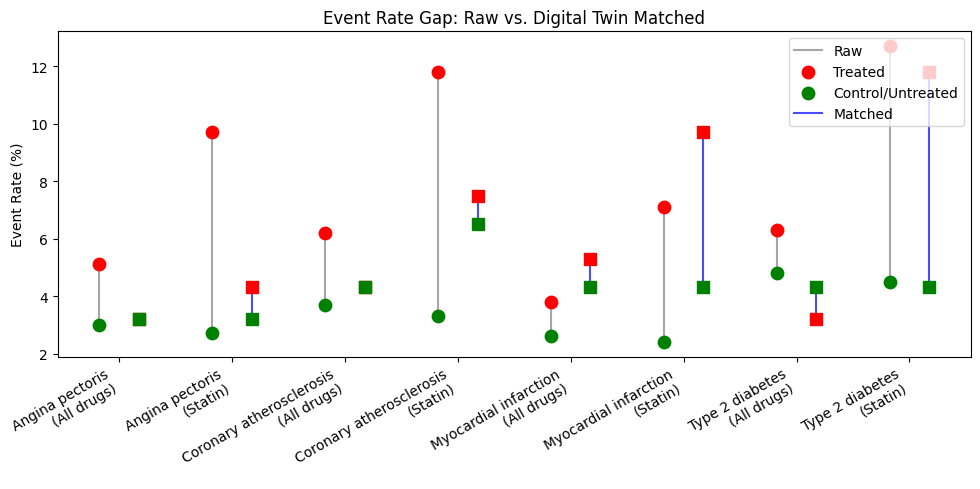

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data (replace with your actual DataFrame)
statin = pd.DataFrame({
    "disease": [
        "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis", "Angina pectoris"
    ],
    "raw_treated_rate": [12.7, 7.1, 11.8, 9.7],
    "raw_untreated_rate": [4.5, 2.4, 3.3, 2.7],
    "matched_treated_rate": [11.8, 9.7, 7.5, 4.3],
    "matched_control_rate": [4.3, 4.3, 6.5, 3.2],
    "label": "Statin"
})

all_drugs = pd.DataFrame({
    "disease": [
        "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis", "Angina pectoris"
    ],
    "raw_treated_rate": [6.3, 3.8, 6.2, 5.1],
    "raw_untreated_rate": [4.8, 2.6, 3.7, 3.0],
    "matched_treated_rate": [3.2, 5.3, 4.3, 3.2],
    "matched_control_rate": [4.3, 4.3, 4.3, 3.2],
    "label": "All drugs"
})

df = pd.concat([statin, all_drugs])

fig, ax = plt.subplots(figsize=(10, 5))

x_labels = []
x = []
width = 0.35

for i, (disease, group) in enumerate(df.groupby("disease")):
    for j, (label, sub) in enumerate(group.groupby("label")):
        idx = i*2 + j
        x_labels.append(f"{disease}\n({label})")
        x.append(idx)
        # Raw
        ax.plot([idx-width/2, idx-width/2], [sub['raw_treated_rate'].values[0], sub['raw_untreated_rate'].values[0]], '-', color='gray', alpha=0.7, label='Raw' if idx==0 else "")
        ax.scatter(idx-width/2, sub['raw_treated_rate'].values[0], color='red', s=80, zorder=3, label='Treated' if idx==0 else "")
        ax.scatter(idx-width/2, sub['raw_untreated_rate'].values[0], color='green', s=80, zorder=3, label='Control/Untreated' if idx==0 else "")
        # Matched
        ax.plot([idx+width/2, idx+width/2], [sub['matched_treated_rate'].values[0], sub['matched_control_rate'].values[0]], '-', color='blue', alpha=0.7, label='Matched' if idx==0 else "")
        ax.scatter(idx+width/2, sub['matched_treated_rate'].values[0], color='red', marker='s', s=80, zorder=3)
        ax.scatter(idx+width/2, sub['matched_control_rate'].values[0], color='green', marker='s', s=80, zorder=3)

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=30, ha='right')
ax.set_ylabel("Event Rate (%)")
ax.set_title("Event Rate Gap: Raw vs. Digital Twin Matched")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

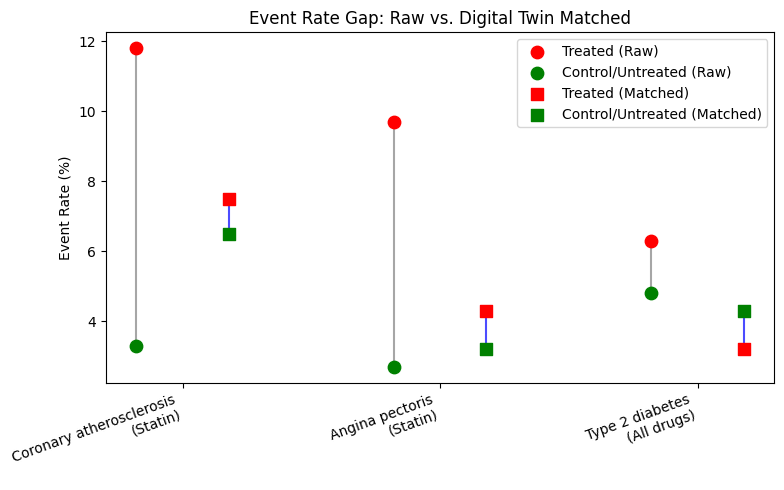

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for selected examples
data = [
    # Statin examples
    {"disease": "Coronary atherosclerosis", "label": "Statin", "raw_treated": 11.8, "raw_control": 3.3, "matched_treated": 7.5, "matched_control": 6.5},
    {"disease": "Angina pectoris", "label": "Statin", "raw_treated": 9.7, "raw_control": 2.7, "matched_treated": 4.3, "matched_control": 3.2},
    # All drugs example
    {"disease": "Type 2 diabetes", "label": "All drugs", "raw_treated": 6.3, "raw_control": 4.8, "matched_treated": 3.2, "matched_control": 4.3},
]

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.18
x = np.arange(len(df))

for i, row in df.iterrows():
    # Raw
    ax.plot([x[i]-width, x[i]-width], [row['raw_treated'], row['raw_control']], '-', color='gray', alpha=0.7)
    ax.scatter(x[i]-width, row['raw_treated'], color='red', s=80, zorder=3, label='Treated (Raw)' if i==0 else "")
    ax.scatter(x[i]-width, row['raw_control'], color='green', s=80, zorder=3, label='Control/Untreated (Raw)' if i==0 else "")
    # Matched
    ax.plot([x[i]+width, x[i]+width], [row['matched_treated'], row['matched_control']], '-', color='blue', alpha=0.7)
    ax.scatter(x[i]+width, row['matched_treated'], color='red', marker='s', s=80, zorder=3, label='Treated (Matched)' if i==0 else "")
    ax.scatter(x[i]+width, row['matched_control'], color='green', marker='s', s=80, zorder=3, label='Control/Untreated (Matched)' if i==0 else "")

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels([f"{row['disease']}\n({row['label']})" for _, row in df.iterrows()], rotation=20, ha='right')
ax.set_ylabel("Event Rate (%)")
ax.set_title("Event Rate Gap: Raw vs. Digital Twin Matched")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:

first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=47,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=100,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [30]:
import numpy as np
import pandas as pd

# Set seeds
import random
random.seed(42)
np.random.seed(42)


# Load data (as in your code)
disease_name = "Coronary atherosclerosis"
disease_idx = disease_names.index(disease_name)
print(disease_idx)
covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov = pd.read_csv(covariate_path, sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['enrollment'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['year_of_birth']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    if isinstance(presc_date, str):
        presc_date = pd.to_datetime(presc_date, errors='coerce')
    if pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid + 30 - age_at_presc)))
first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=disease_idx,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=200,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

114
Raw Treated Event Rate: 6.23% (n=112982)
Raw Untreated Event Rate: 3.73% (n=282177)
Treated event rate: 0.03763440860215054
Control event rate: 0.021505376344086023
Number of matched pairs: 193


In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

IPW Treated Event Rate: 5.63%
IPW Untreated Event Rate: 3.93%


In [21]:
import pandas as pd

data = [
    # Type 2 diabetes
    {"Disease": "Type 2 diabetes", "Group": "Raw", "Treated": 6.31, "Untreated": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched", "Treated": 3.19, "Untreated": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW", "Treated": 6.16, "Untreated": 5.02},
    # Myocardial infarction
    {"Disease": "Myocardial infarction", "Group": "Raw", "Treated": 3.80, "Untreated": 2.60},
    {"Disease": "Myocardial infarction", "Group": "Matched", "Treated": 5.32, "Untreated": 4.26},
    {"Disease": "Myocardial infarction", "Group": "IPW", "Treated": 3.87, "Untreated": 2.77},
    # CAD
    {"Disease": "CAD", "Group": "Raw", "Treated": 6.23, "Untreated": 3.73},
    {"Disease": "CAD", "Group": "Matched", "Treated": 3.76, "Untreated": 2.15},
    {"Disease": "CAD", "Group": "IPW", "Treated": 5.63, "Untreated": 3.93},
]

df = pd.DataFrame(data)
df["Relative Increase (%)"] = 100 * (df["Treated"] - df["Untreated"]) / df["Untreated"]

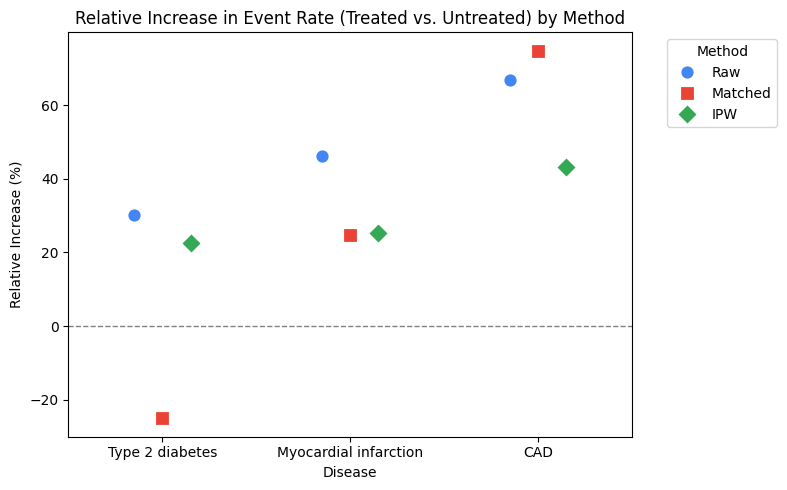

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=df,
    x="Disease",
    y="Relative Increase (%)",
    hue="Group",
    palette=["#4285F4", "#EA4335", "#34A853"],
    dodge=0.3,
    markers=["o", "s", "D"],
    linestyles=""
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Relative Increase in Event Rate (Treated vs. Untreated) by Method")
plt.ylabel("Relative Increase (%)")
plt.xlabel("Disease")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'scripts' is not defined

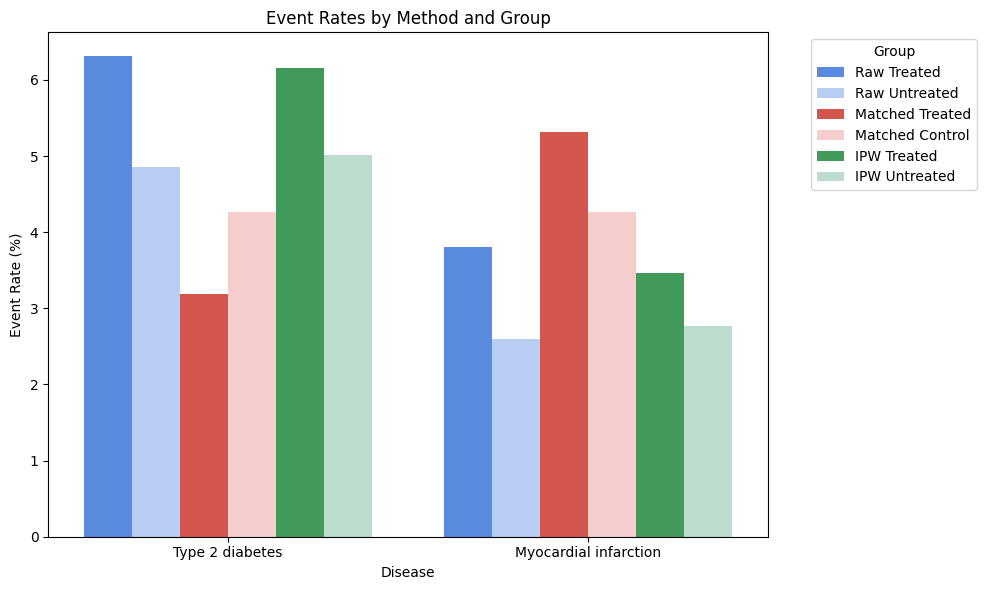

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the order for groups for consistent coloring
group_order = [
    "Raw Treated", "Raw Untreated",
    "Matched Treated", "Matched Control",
    "IPW Treated", "IPW Untreated"
]

palette = {
    "Raw Treated": "#4285F4",
    "Raw Untreated": "#AECBFA",
    "Matched Treated": "#EA4335",
    "Matched Control": "#FBC7C7",
    "IPW Treated": "#34A853",
    "IPW Untreated": "#B7E1CD"
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="Disease",
    y="Event Rate",
    hue="Group",
    hue_order=group_order,
    palette=palette
)
plt.title("Event Rates by Method and Group")
plt.ylabel("Event Rate (%)")
plt.xlabel("Disease")
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

df = pd.DataFrame([
 {"Disease": "Type 2 diabetes", "Group": "Raw Treated", "Event Rate": 6.31},
    {"Disease": "Type 2 diabetes", "Group": "Raw Untreated", "Event Rate": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched Treated", "Event Rate": 3.19},
    {"Disease": "Type 2 diabetes", "Group": "Matched Control", "Event Rate": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW Treated", "Event Rate": 6.16},
    {"Disease": "Type 2 diabetes", "Group": "IPW Untreated", "Event Rate": 5.02},
    # Repeat for MI and Cerebrovascular
 ])


df["Relative Increase (%)"] = 100 * (df["Treated"] - df["Untreated"]) / df["Untreated"]

KeyError: 'Treated'

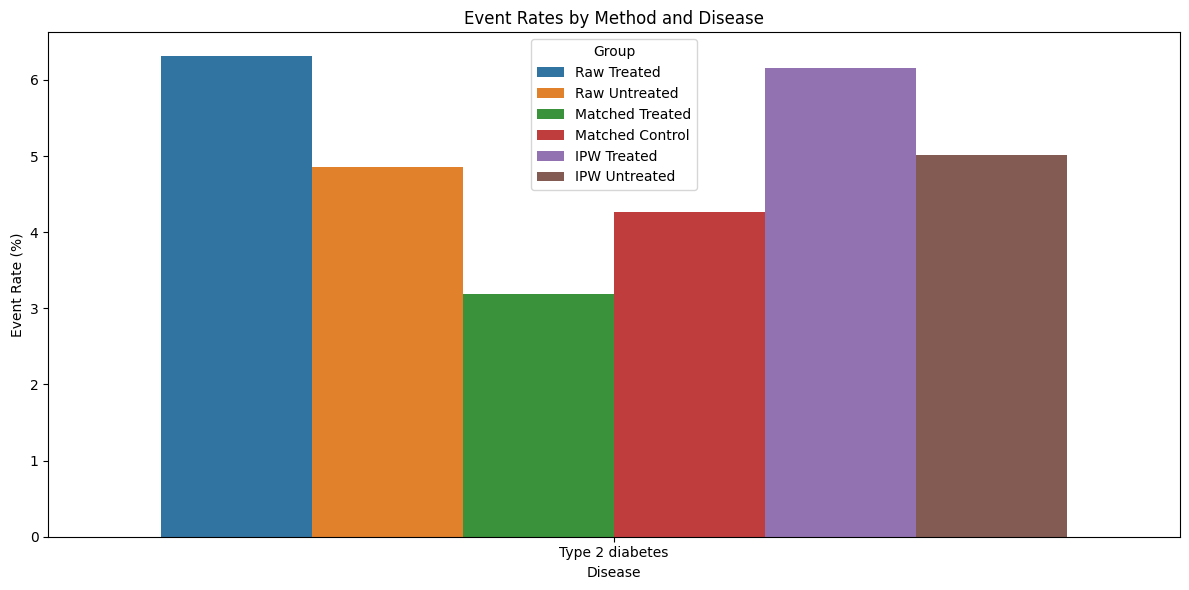

<Figure size 1000x400 with 0 Axes>

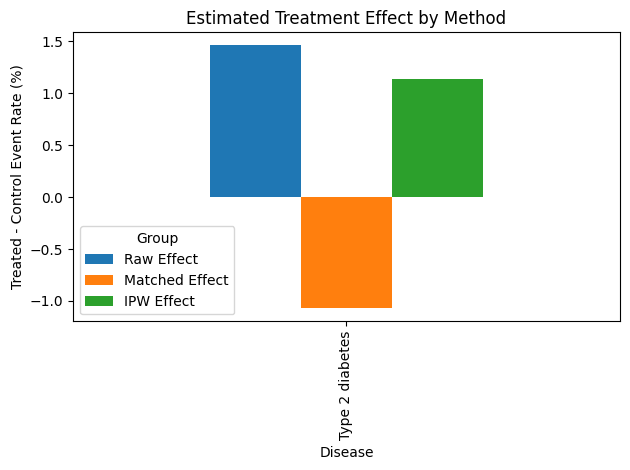

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: fill in your real results
summary = pd.DataFrame([
    {"Disease": "Type 2 diabetes", "Group": "Raw Treated", "Event Rate": 6.31},
    {"Disease": "Type 2 diabetes", "Group": "Raw Untreated", "Event Rate": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched Treated", "Event Rate": 3.19},
    {"Disease": "Type 2 diabetes", "Group": "Matched Control", "Event Rate": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW Treated", "Event Rate": 6.16},
    {"Disease": "Type 2 diabetes", "Group": "IPW Untreated", "Event Rate": 5.02}
    # Cerebrovascular: fill in your numbers
])

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x="Disease", y="Event Rate", hue="Group")
plt.title("Event Rates by Method and Disease")
plt.ylabel("Event Rate (%)")
plt.xlabel("Disease")
plt.legend(title="Group")
plt.tight_layout()
plt.show()


# Calculate effect size for each method/disease
effect_df = summary.pivot(index="Disease", columns="Group", values="Event Rate").reset_index()
effect_df["Raw Effect"] = effect_df["Raw Treated"] - effect_df["Raw Untreated"]
effect_df["Matched Effect"] = effect_df["Matched Treated"] - effect_df["Matched Control"]
effect_df["IPW Effect"] = effect_df["IPW Treated"] - effect_df["IPW Untreated"]

# Waterfall plot for matched and IPW effect
plt.figure(figsize=(10, 4))
effect_df.plot(x="Disease", y=["Raw Effect", "Matched Effect", "IPW Effect"], kind="bar")
plt.ylabel("Treated - Control Event Rate (%)")
plt.title("Estimated Treatment Effect by Method")
plt.tight_layout()
plt.show()

In [3]:
effect_df = df.pivot(index="Disease", columns="Group", values="Event Rate").reset_index()
effect_df["Raw Effect"] = effect_df["Raw Treated"] - effect_df["Raw Untreated"]
effect_df["Matched Effect"] = effect_df["Matched Treated"] - effect_df["Matched Control"]
effect_df["IPW Effect"] = effect_df["IPW Treated"] - effect_df["IPW Untreated"]

plt.figure(figsize=(8, 4))
effect_df.set_index("Disease")[["Raw Effect", "Matched Effect", "IPW Effect"]].plot(kind="bar")
plt.ylabel("Treated - Control Event Rate (%)")
plt.title("Estimated Treatment Effect by Method")
plt.tight_layout()
plt.show()

KeyError: 'Event Rate'

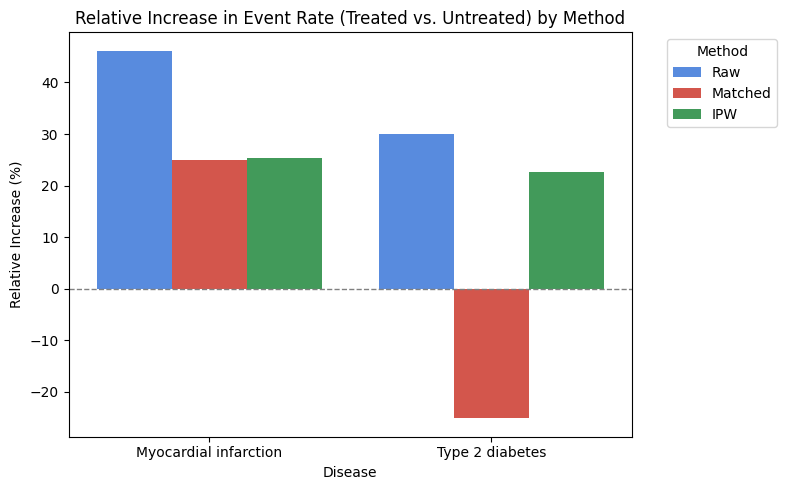

In [16]:
# Calculate relative increase for each method
effect_df["Raw Relative Increase (%)"] = 100 * (effect_df["Raw Treated"] - effect_df["Raw Untreated"]) / effect_df["Raw Untreated"]
effect_df["Matched Relative Increase (%)"] = 100 * (effect_df["Matched Treated"] - effect_df["Matched Control"]) / effect_df["Matched Control"]
effect_df["IPW Relative Increase (%)"] = 100 * (effect_df["IPW Treated"] - effect_df["IPW Untreated"]) / effect_df["IPW Untreated"]

# Prepare for plotting
rel_effect_df = effect_df[["Disease", "Raw Relative Increase (%)", "Matched Relative Increase (%)", "IPW Relative Increase (%)"]]
rel_effect_df = rel_effect_df.melt(id_vars="Disease", var_name="Method", value_name="Relative Increase (%)")

# Clean up method names for legend
rel_effect_df["Method"] = rel_effect_df["Method"].str.replace(" Relative Increase (%)", "")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=rel_effect_df,
    x="Disease",
    y="Relative Increase (%)",
    hue="Method",
    palette=["#4285F4", "#EA4335", "#34A853"]
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Relative Increase in Event Rate (Treated vs. Untreated) by Method")
plt.ylabel("Relative Increase (%)")
plt.xlabel("Disease")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()